# We are checking how sparsely the Argo floats occupy this area over the course of two years (Jan 2022 - Dec 2024)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from argopy import DataFetcher

In [63]:
# --- PART A: FETCH THE DATA (Creating final_ds) ---
# We focus on the "Super El Niño" winter to test coverage
lon_min = -126
lon_max = -120
lat_min = 30
lat_max = 40
depth_min = 0
depth_max = 500
region_box = [lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]  # [Lon_min, Lon_max, Lat_min, Lat_max, Depth_min, Depth_max]
start_date = '2016-01-01'
end_date   = '2016-02-01'

print(f"⬇️ Fetching Argo data for {start_date} to {end_date}...")

⬇️ Fetching Argo data for 2016-01-01 to 2016-02-01...


# as of December 15, the ifremer server appears to be down. Hopefully it comes back soon. But! I do have some data saved, thank goodness. 

# YOUR VPN COULD HAVE MESSED YOU UP!

In [16]:
try:
    # 1. Init Fetcher
    loader = DataFetcher()
    
    # 2. Request Data (The missing step!)
    # We load it into a temporary variable 'ds_raw' first
    ds_raw = loader.region(region_box + [start_date, end_date]).to_xarray()
    
    # 3. Check if we actually got data
    if ds_raw.sizes['N_PROF'] > 0:
        print(f"   Raw data downloaded: {ds_raw.sizes['N_PROF']} profiles.")

        # 4. Interpolate to standard levels
        std_levels = np.arange(0, 501, 10) # 0 to 500m every 10m
        final_ds = ds_raw.argo.interp_std_levels(std_levels)
        
        # 5. Clean up Time Coordinate
        final_ds['TIME'] = pd.to_datetime(final_ds['TIME'].values)
        
        print(f"✅ Success! 'final_ds' created and interpolated.")
    else:
        print("⚠️ Download successful, but region is empty for this month.")

except Exception as e:
    print(f"❌ Error during fetch: {e}")

❌ Error during fetch: Cannot connect to host erddap.ifremer.fr:443 ssl:default [Name or service not known]


#  SKIP TO HERE TO IGNORE DATA LOAD

In [20]:
final_ds = xr.load_dataset('FailedRefugiaProject/california_current_argo_2021_2024.nc')

In [29]:
final_ds.TIME

<xarray.DataArray 'TIME' (N_PROF: 1558)> Size: 12kB
array(['2022-01-03T06:08:53.000000000', '2022-01-05T22:35:39.000000000',
       '2022-01-06T05:51:01.000000000', ...,
       '2024-12-28T14:20:39.000000000', '2024-12-29T03:34:37.000000000',
       '2024-12-30T16:30:20.000000000'], dtype='datetime64[ns]')
Coordinates:
  * N_PROF     (N_PROF) int64 12kB 32 1369 419 549 1041 ... 1141 31 1039 1200
    LATITUDE   (N_PROF) float64 12kB 31.44 35.36 31.39 ... 32.39 35.05 35.94
    LONGITUDE  (N_PROF) float64 12kB -125.3 -125.1 -123.3 ... -122.0 -124.2
    TIME       (N_PROF) datetime64[ns] 12kB 2022-01-03T06:08:53 ... 2024-12-3...
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [1.64103728e+09 1.73557622e+09]
    axis:                 T
    ioos_category:        Time
    long_name:            Julian day (UTC) of the station relative to REFEREN...
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00
    casted:               1


🕵️‍♀️ Running Sparsity Audit on previoiusly saved data...
   Total Grid Cells: 60
   Empty Cells: 0
   Void Percentage: 0.0%


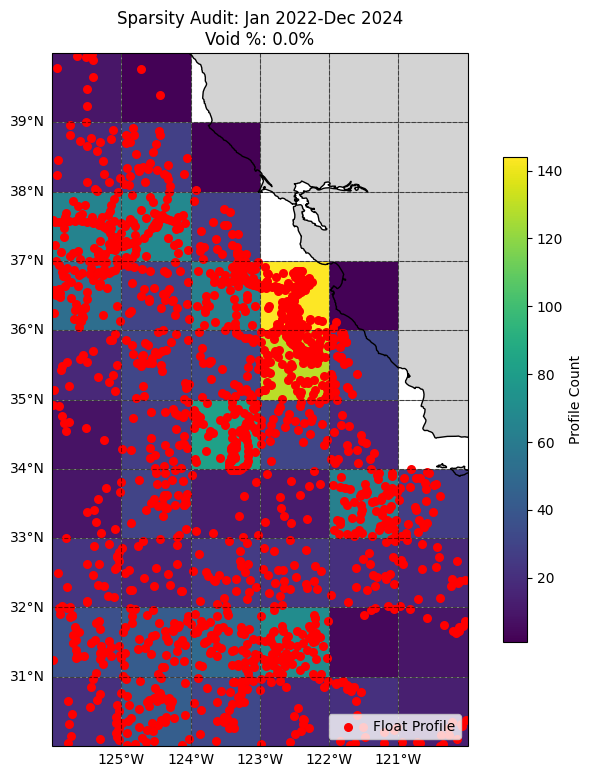

✅ DECISION: Low Sparsity. Binning is acceptable.


In [ ]:
# --- PART B: THE SPARSITY AUDIT ---
# Only run if fetch succeeded
if final_ds is not None:
    print(f"\n🕵️‍♀️ Running Sparsity Audit on previoiusly saved data...")

    # 1. Extract Locations
    lats = final_ds['LATITUDE'].values
    lons = final_ds['LONGITUDE'].values

    # 2. Define Grid (1x1 degree)
    grid_res = 1.0
    lon_edges = np.arange(-126, -119, grid_res) # -119 ensures we include -120 edge
    lat_edges = np.arange(30, 41, grid_res)     # 41 ensures we include 40 edge

    # 3. Count Floats per Cell
    # hist is a 2D array: rows=x(lon), cols=y(lat)
    hist, _, _ = np.histogram2d(lons, lats, bins=(lon_edges, lat_edges))
    hist = hist.T  # Transpose for correct mapping (Lat=Rows, Lon=Cols)

    # 4. Calculate Metrics
    total_cells = hist.size
    empty_cells = np.sum(hist == 0) - 13 #(THIS CHOICE OF REGION INCLUDES 13 EMPTY CELLS)
    void_percent = (empty_cells / total_cells) * 100

    print(f"   Total Grid Cells: {total_cells}")
    print(f"   Empty Cells: {empty_cells}")
    print(f"   Void Percentage: {void_percent:.1f}%")

    # 5. Visualize
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([-126, -120, 30, 40])

    # Plot Voids (White) vs Data (Color)
    # We mask the Zeros so they show as "empty" (white) rather than purple/blue
    hist_masked = np.ma.masked_where(hist == 0, hist)
    
    mesh = ax.pcolormesh(lon_edges, lat_edges, hist_masked, 
                         cmap='viridis', transform=ccrs.PlateCarree(),
                         edgecolors='gray', linewidth=0.5)
    
    # Plot Actual Floats
    ax.scatter(lons, lats, color='red', s=30, label='Float Profile', transform=ccrs.PlateCarree())

    # Add Gridlines matching the analysis bins
    gl = ax.gridlines(draw_labels=True, xlocs=lon_edges, ylocs=lat_edges, 
                      linestyle='--', alpha=0.5, color='black')
    gl.top_labels = False
    gl.right_labels = False

    plt.colorbar(mesh, label='Profile Count', shrink=0.7)
    plt.title(f"Sparsity Audit: Jan 2022-Dec 2024\nVoid %: {void_percent:.1f}%")
    plt.legend(loc='lower right')
    plt.show()


In [54]:
target_year = 2022
target_month = 2
grid_res = 1.0

In [55]:
np.where((times.year == target_year) & (times.month == target_month))[0]

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76, 77, 78, 79, 80, 81, 82])


🕵️‍♀️ Running Sparsity Audit on previoiusly saved data...
   Total Grid Cells: 60
   Empty Cells: 35
   Void Percentage: 58.3%


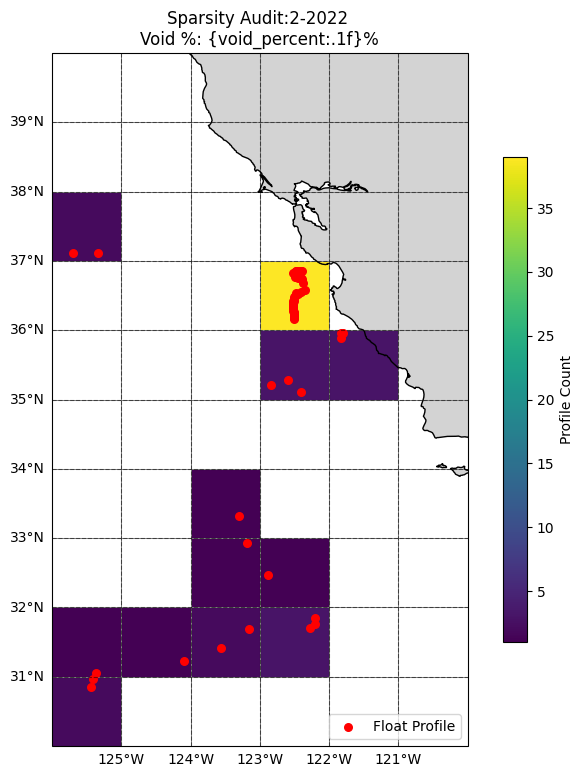

🚨 DECISION: High Sparsity (>20%). GPR (Kriging) is required.


In [ ]:
# --- PART B: THE SPARSITY AUDIT ---
# Only run if fetch succeeded
if final_ds is not None:
    print(f"\n🕵️‍♀️ Running Sparsity Audit on previoiusly saved data...")

    # 1. Extract Locations
    times = pd.to_datetime(final_ds['TIME'].values)
    mask = (times.year == target_year) & (times.month == target_month);
    indices = np.where(mask)[0]
    if (len(indices) == 0):
        print('Sorry, no times fit your requirements.')
    else:
        lats = final_ds['LATITUDE'].values[indices]
        lons = final_ds['LONGITUDE'].values[indices]

        # 2. Define Grid (1x1 degree)
        grid_res = 1.0
        lon_edges = np.arange(-126, -119, grid_res) # -119 ensures we include -120 edge
        lat_edges = np.arange(30, 41, grid_res)     # 41 ensures we include 40 edge

        # 3. Count Floats per Cell
        # hist is a 2D array: rows=x(lon), cols=y(lat)
        hist, _, _ = np.histogram2d(lons, lats, bins=(lon_edges, lat_edges))
        hist = hist.T  # Transpose for correct mapping (Lat=Rows, Lon=Cols)

        # 4. Calculate Metrics
        total_cells = hist.size
        empty_cells = np.sum(hist == 0) - 13 #(THIS CHOICE OF REGION INCLUDES 13 EMPTY CELLS)
        void_percent = (empty_cells / total_cells) * 100

        print(f"   Total Grid Cells: {total_cells}")
        print(f"   Empty Cells: {empty_cells}")
        print(f"   Void Percentage: {void_percent:.1f}%")

        # 5. Visualize
        fig = plt.figure(figsize=(9, 9))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.set_extent([-126, -120, 30, 40])

        # Plot Voids (White) vs Data (Color)
        # We mask the Zeros so they show as "empty" (white) rather than purple/blue
        hist_masked = np.ma.masked_where(hist == 0, hist)
        
        mesh = ax.pcolormesh(lon_edges, lat_edges, hist_masked, 
                            cmap='viridis', transform=ccrs.PlateCarree(),
                            edgecolors='gray', linewidth=0.5)
        
        # Plot Actual Floats
        ax.scatter(lons, lats, color='red', s=30, label='Float Profile', transform=ccrs.PlateCarree())

        # Add Gridlines matching the analysis bins
        gl = ax.gridlines(draw_labels=True, xlocs=lon_edges, ylocs=lat_edges, 
                        linestyle='--', alpha=0.5, color='black')
        gl.top_labels = False
        gl.right_labels = False

        plt.colorbar(mesh, label='Profile Count', shrink=0.7)
        plt.title(f"Sparsity Audit:" + str(target_month) + "-" + str(target_year)")
        plt.legend(loc='lower right')
        plt.show()

        # 6. The Verdict
        if void_percent > 20:
            print("🚨 DECISION: High Sparsity (>20%). GPR (Kriging) is required.")
        else:
            print("✅ DECISION: Low Sparsity. Binning is acceptable.")

In [57]:
np.sum(hist)

59.0

In [64]:
void_percent_list = [] # at every time, how high is the void percentage
float_total_list = [] # at every time, how high is the number of floats
hist_occupied_score = np.zeros((np.abs(lat_min - lat_max), np.abs(lon_min - lon_max))) # in space, how many times is a grid region occupied
for target_year in range(2022,2025):
    for target_month in range(1,13):
        times = pd.to_datetime(final_ds['TIME'].values)
        mask = (times.year == target_year) & (times.month == target_month);
        indices = np.where(mask)[0]
        if (len(indices) == 0):
            print('Sorry, no times fit your requirements.')
        else:
            lats = final_ds['LATITUDE'].values[indices]
            lons = final_ds['LONGITUDE'].values[indices]

            # 2. Define Grid (1x1 degree)
            grid_res = 1.0
            lon_edges = np.arange(-126, -119, grid_res) # -119 ensures we include -120 edge
            lat_edges = np.arange(30, 41, grid_res)     # 41 ensures we include 40 edge

            # 3. Count Floats per Cell
            # hist is a 2D array: rows=x(lon), cols=y(lat)
            hist, _, _ = np.histogram2d(lons, lats, bins=(lon_edges, lat_edges))
            hist = hist.T  # Transpose for correct mapping (Lat=Rows, Lon=Cols)
            hist_occupied_score += np.heaviside(hist,0)
            # 4. Calculate Metrics
            total_cells = hist.size
            empty_cells = np.sum(hist == 0) - 13 #(THIS CHOICE OF REGION INCLUDES 13 EMPTY CELLS WHICH ARE LAND)
            void_percent = (empty_cells / total_cells) * 100
            float_total_list.append(np.sum(hist))
            void_percent_list.append(void_percent)
            #print(f"   Total Grid Cells: {total_cells}")
            #print(f"   Empty Cells: {empty_cells}")
            #print(f"   Void Percentage: {void_percent:.1f}%")

In [62]:
hist.shape

(10, 6)

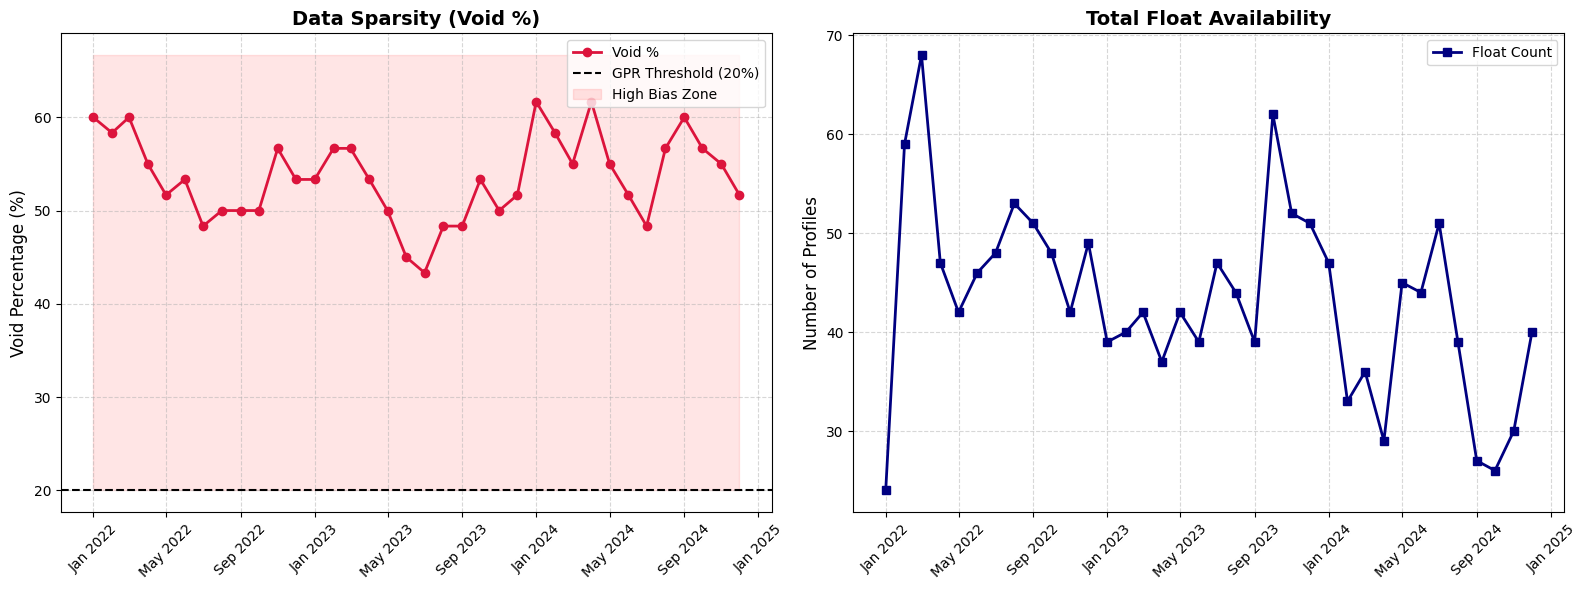

In [59]:
import matplotlib.dates as mdates
dates = pd.date_range(start='2022-01-01', periods=len(void_percent_list), freq='MS')

# --- 2. CREATE PLOT ---
# 1 Row, 2 Columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# --- PANEL 1: VOID PERCENTAGE (The "Quality" Metric) ---
ax1.plot(dates, void_percent_list, color='crimson', marker='o', linewidth=2, label='Void %')
ax1.set_title("Data Sparsity (Void %)", fontsize=14, fontweight='bold')
ax1.set_ylabel("Void Percentage (%)", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)

# Add the critical threshold line
ax1.axhline(y=20, color='black', linestyle='--', linewidth=1.5, label='GPR Threshold (20%)')
ax1.fill_between(dates, 20, max(void_percent_list) + 5, color='red', alpha=0.1, label='High Bias Zone')
ax1.legend(loc='upper right')

# --- PANEL 2: FLOAT COUNT (The "Quantity" Metric) ---
ax2.plot(dates, float_total_list, color='navy', marker='s', linewidth=2, label='Float Count')
ax2.set_title("Total Float Availability", fontsize=14, fontweight='bold')
ax2.set_ylabel("Number of Profiles", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(loc='upper right')

# --- FORMATTING ---
# Rotate dates for readability
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

High Bias Zone is just anywhere above 20%. 

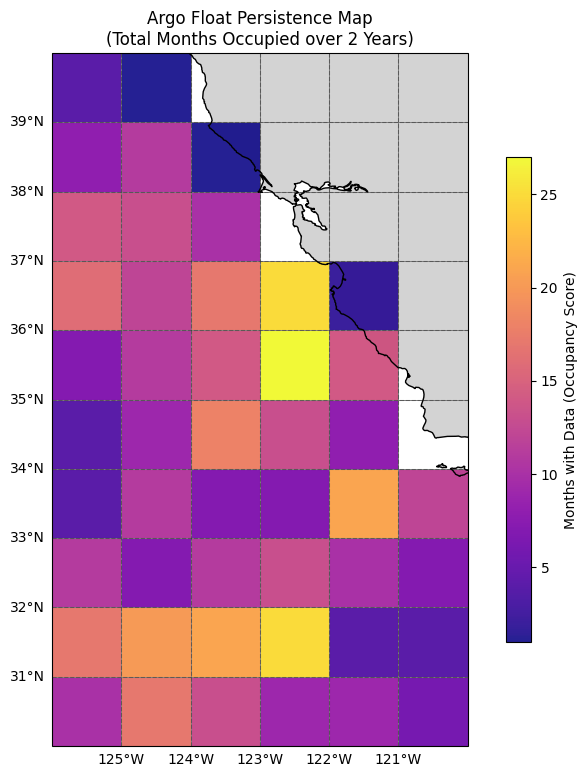

In [ ]:
# --- 2. MASKING THE ZEROS ---
# This hides the empty cells so they appear white (transparent)
score_masked = np.ma.masked_where(hist_occupied_score == 0, hist_occupied_score)

# --- 3. PLOT THE OCCUPANCY SCORE ---
fig = plt.figure(figsize=(10, 9))
ax = plt.axes(projection=ccrs.PlateCarree())

# Map Features
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=2)
ax.set_extent([-126, -120, 30, 40])

# The Heatmap
# 'plasma' is great for scores because it goes from purple (low) to bright yellow (high)
mesh = ax.pcolormesh(lon_edges, lat_edges, score_masked, 
                     cmap='plasma', 
                     transform=ccrs.PlateCarree(),
                     edgecolors='grey', linewidth=0.5, alpha=0.9)

# Colorbar
cb = plt.colorbar(mesh, label='Months with Data (Occupancy Score)', shrink=0.7)

# Title & Grid
plt.title(f"Argo Float Persistence Map\n(Total Months Occupied beteen Jan 2022-Dec 2024)")
gl = ax.gridlines(draw_labels=True, xlocs=lon_edges, ylocs=lat_edges, 
                  linestyle='--', alpha=0.3, color='black')
gl.top_labels = False
gl.right_labels = False

plt.show()